## MFPT computation using Langevin's equation

Uses `langevin-survival.cpp` or `langevin-survival-simplified-2d.cpp` to compute 1D or 2D MFPT.

Things to specify in `langevin-survival.cpp` :
 - For the overdamped Langevin equation (no inertia), set `#define LANGEVIN_OVERDAMPED`. For studying finite mass effects, `#undef LANGEVIN_OVERDAMPED` and set `simul['part_m']` below
 - `#undef ENABLE_SURVIVAL_PROBABILITIES_*`
 - For 1D target, `#define FPT_JUMP_ACROSS` (prefered) or `#define FPT_INTERVAL`. Alternatively, for $\sigma=0$ *only*, `#define FPT_DEMISPACE` can be used (much faster $\to$ assumes that the particules comes from $x=0$ only, and hits the target with increasing $x$)
 - For 2D target, `#define TARGET_2D_CYL` and choose `simul['2D-Rtol']` below
 - Choose target(s) distance(s) in `first_times_xtarg = {...}`. Warning : far-away targets increases the MFPT so the simulation is much slower
 - Choose `Δt`
 - Resetting :
  - for poissonian resetting, `#define ENABLE_POISSON_RESET`, and set `simul['reset_rate']` and `reset_type='poisson'` below
  - for periodical resetting, `#define ENABLE_PERIODICAL_RESET`, and set `simul['reset_period']` and `reset_type='per'` below
  - without resetting, no additional #define, and set `reset_type='none'`

For studying the 2D target case only, `langevin-survival-simplified-2d.cpp` can be used, and must be specified :
 - `#define ENABLE_POISSON_RESET` or `#define ENABLE_PERIODICAL_RESET`
 - `first_times_xtarg` and `Δt`
 
Then define parameters $T$, $\gamma$ (or only `D` for `langevin-survival-simplified-2d.cpp`), $\sigma$, $T_\text{res}$/$\alpha$ below.

In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import pysimul
from common import *
from math import *

In [2]:
simul = pysimul.PySimul()
simul['T'] = T = 1
simul['gamma'] = gamma = 0.2
D = T / gamma
#simul['D'] = D = 1  # for langevin-survival-simplified-2d.cpp
part_m = 0
simul['part_m'] = part_m = 0.0001
reset_type = 'per'
#simul['reset_rate'] = α = 25
simul['reset_period'] = rT = 0.2
simul['x0sigma'] = σ = sqrt(0.1)
simul['2D-Rtol'] = Rtol = 0.08
target_2D = False
path = "../test/"

In [3]:
if reset_type == 'none':
    th_fpt_distrib = None # TODO
    th_tau = th_tau_2d = None
    th_c = None
elif reset_type == 'poisson':
    th_fpt_distrib = None # TODO
    if not target_2D:
        th_tau = fpt_poisson_tau
    else:
        th_tau_2d = fpt_2d_poisson_tau
    th_c = lambda L: fpt_poisson_c(α, D, L)
elif reset_type == 'per':
    if not target_2D:
        th_fpt_distrib = lambda t, b, c: fpt_periodic_disrib(t, rT, b, c)
        th_tau = fpt_periodic_tau
    else:
        th_fpt_distrib = None # TODO
        th_tau_2d = fpt_2d_periodical_tau
    th_c = lambda L: fpt_periodic_c(rT, D, L)
tau_th_cache = None

In [4]:
simul.start()

In [ ]:
simul.end()

In [23]:
simul['n_trajectories']

10787

In [ ]:
simul['pause'] = 1

### MFPT saving

Choose the starting prefix-number for resulting files (one pair for each target) `*-ft.csv` (list of first times) and `*-params.csv` (point in the MFPT-$b$-$c$-($a$) diagram, used by `langevin-mfpt.ipynb`).

In [20]:
i_beg = 0

In [21]:
Res = pd.DataFrame()
simul.explicit_lock()
first_times_xtarg = simul['first_times_xtarg']
Δt = simul['Delta_t']
for i in range(len(first_times_xtarg)):
    x_targ = first_times_xtarg[i]
    if target_2D and x_targ < Rtol*1.001:
        continue
    first_times = simul['first_times-'+str(i)]
    path2 = path+str(i+i_beg)
    np.savetxt(path2+"-ft.csv", first_times, fmt='%.2e')
    d = {
        'D': D,
        'T': T,
        'gamma': gamma,
        'part_m': part_m,
        'x0sigma': σ,
        'L': x_targ,
        'b': x_targ/σ,
        'c': th_c(x_targ),
        'mfpt': np.mean(first_times),
        'fpt_stdev': np.std(first_times),
        'n_traj': len(first_times),
        'Delta_t': Δt
    }
    if reset_type == 'none':
        pass
    elif reset_type == 'poisson':
        d['reset_rate'] = α
    elif reset_type == 'per':
        d['reset_period'] = rT
    if target_2D:
        d['Rtol'] = Rtol
        d['a'] = Rtol / x_targ
    else:
        d['L_err'] = simul['xtarg_tol']
        d['c_err'] = th_c(simul['xtarg_tol'])
    df = pd.DataFrame(list(d.items())).set_index(0)
    df.to_csv(path2+"-params.csv", header=False, quoting=csv.QUOTE_NONE, sep=',')
    Res = Res.append(df.T, ignore_index=True, sort=False)
simul.explicit_unlock()

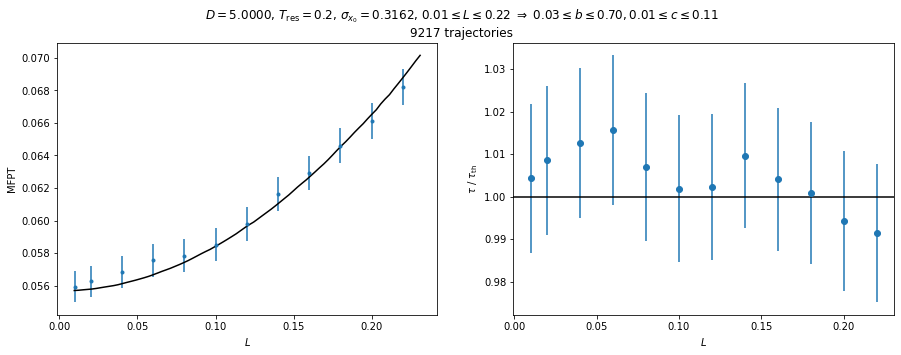

In [22]:
Res['mfpt_err'] = Res['fpt_stdev']/np.sqrt(Res['n_traj'])

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
L = np.linspace(np.min(Res['L'])*0.95, np.max(Res['L'])*1.05, 80)
b = L/σ
if tau_th_cache is not None:
    ax1.plot(L, L**2/(4*D)*tau_th_cache, color='black')
ax1.errorbar(Res['L'], Res['mfpt'], yerr=Res['mfpt_err'], fmt='.')
ax1.set_ylabel(r"MFPT")
if not target_2D:
    mfpt_th = Res['L']**2/(4*D) * th_tau(Res['b'],Res['c'])
else:
    mfpt_th = Res['L']**2/(4*D) * th_tau_2d(Res['b'],Res['c'],Res['a'])
ax2.errorbar(Res['L'], Res['mfpt']/mfpt_th, yerr=Res['mfpt_err']/mfpt_th, fmt='o')
ax2.axhline(y=1, color='black')
ax2.set_ylabel(r"$\tau\ /\ \tau_\operatorname{th}$")
add_params1 = add_params2 = ""
if target_2D:
    add_params1 = r", $R_\operatorname{{tol}}={}$".format(Rtol)
    add_params2 = r", ${:.2f} \leq a \leq {:.2f}$".format(np.min(Res['a']), np.max(Res['a']))
    xlabel = r"$R_\operatorname{targ}$"
else:
    xlabel = r"$L$"
ax1.set_xlabel(xlabel)
ax2.set_xlabel(xlabel)
if reset_type == 'poisson':
    fig.suptitle(r"$D={:.4f}$, $\alpha={}$, $\sigma_{{x_0}}={:.4f}$".format(D, α, σ)+add_params1+(r", ${} \leq L \leq {} \ \Rightarrow \  {:.2f} \leq b \leq {:.2f}, {:.2f} \leq c \leq {:.2f}$"+add_params2+"\n{} trajectories, $\Delta t={}$").format(np.min(Res['L']), np.max(Res['L']), np.min(Res['b']), np.max(Res['b']), np.min(Res['c']), np.max(Res['c']), int(Res['n_traj'].iloc[0]), Δt))
elif reset_type == 'per':
    fig.suptitle((r"$D={:.4f}$, $T_\operatorname{{res}}={}$, $\sigma_{{x_0}}={:.4f}$, ${} \leq L \leq {} \ \Rightarrow \  {:.2f} \leq b \leq {:.2f}, {:.2f} \leq c \leq {:.2f}$"+"\n{} trajectories").format(D, rT, σ, np.min(Res['L']), np.max(Res['L']), np.min(Res['b']), np.max(Res['b']), np.min(Res['c']), np.max(Res['c']), int(Res['n_traj'].iloc[0])))
plt.savefig(path+str(i_beg)+"-summary.pdf", bbox_inches='tight')
plt.show()
if tau_th_cache is None:
    if not target_2D:
        tau_th_cache = th_tau(b, c=th_c(L))
    else:
        tau_th_cache = th_tau_2d(b, c=th_c(L), a=Rtol/L)

---
### FPT distrubution for one $L$

Choose a target n° `i`.

In [ ]:
i = 1
simul.explicit_lock()
first_times = simul['first_times-'+str(i)]
n_traj = len(first_times)
if simul['n_trajectories'] != n_traj and not target_2D:
    print("Number of trajectories don't match up !")
L = simul['first_times_xtarg'][i]
simul.explicit_unlock()
b = L/σ
c = th_c(L)
if not target_2D:
    mfpt_th = L**2/(4*D)*th_tau(b,c)
else:
    a = Rtol/L
    mfpt_th = L**2/(4*D)*th_tau_2d(b,c,a)
mfpt = np.mean(first_times)

print("number of FPT events ≤ 2·Δt : {:.2f}%".format( np.sum(first_times < 2.1*Δt) / len(first_times) *100 ))

def fpt_distrib_title ():
    plt.xlabel("first passage time")
    if reset_type == 'poisson':
        plt.title(r"FPT distribution for $b={:.2f}$, $c={:.2f}$ ($D={:.3f}$, $\alpha={}$, $\sigma_{{x_0}}={:.3e}$, $L={}$)".format(b, c, D, α, σ, L))
    elif reset_type == 'per':
        plt.title(r"FPT distribution for $b={:.2f}$, $c={:.2f}$ ($D={:.3f}$, $T_\operatorname{{res}}={}$, $\sigma_{{x_0}}={:.3e}$, $L={}$)".format(b, c, D, rT, σ, L))
    plt.legend()

In [ ]:
plt.figure(figsize=(10,4))
fpt_max = 10*mfpt_th
plt.hist(first_times, bins=20, range=(0,fpt_max), weights=20/fpt_max*np.ones(n_traj)/n_traj, label="distribution ({} traj.)".format(n_traj))
plt.axvline(x=mfpt, color='purple', label="MFPT = {:.3f}".format(mfpt))
plt.yscale('log')
fpt_distrib_title()
None

In [ ]:
if reset_type == 'per' and not target_2D:
    fpt_max = 0.999*max(3, ceil(2*mfpt_th/rT))*rT
    t_th = np.linspace(0, fpt_max, 400)+3e-4
    d_th = -( fpt_periodic_survival(t_th+1e-4, rT, b, c) - fpt_periodic_survival(t_th-1e-4, rT, b, c) ) / 2e-4
elif reset_type == 'poisson' and not target_2D:
    fpt_max = 5*mfpt_th
    t_th = np.logspace(log(mfpt_th/20/b), log(fpt_max), 50, base=np.e)
    d_th = fpt_poisson_distrib(L, t_th, α, D, σ)
else:
    fpt_max = 5*mfpt_th
    t_th = None

def do_fpt_distrib (log=True):
    global fpt_max, t_th, d_th
    plt.figure(figsize=(12,4))
    _,bins,_ = plt.hist(first_times, bins=200, range=(0,fpt_max), weights=200/fpt_max*np.ones(n_traj)/n_traj, label="distribution ({} traj.)".format(n_traj))
    plt.axvline(x=mfpt, color='purple', label="MFPT (mes.) = {:.3f}".format(mfpt))
    plt.axvline(x=mfpt_th, color='black', label="MFPT (th.) = {:.3f}".format(mfpt_th))
    if t_th is not None:
        plt.plot(t_th, d_th, label=r"theoretical distrib.", color='black', linestyle='dashed', lw=3, alpha=0.6)
    if log:
        plt.yscale('log')
    fpt_distrib_title()
    plt.savefig(path+str(i+i_beg)+"-fpt-"+("log" if log else "lin")+".pdf", bbox_inches='tight')

do_fpt_distrib(True)
do_fpt_distrib(False)